# 05 — Hedging Portfolio with VIX Futures

In this notebook we investigate how to hedge exposure to equities using the VIX.

Exposure to the VIX index is in general hard to achieve for investers. It can be achieved through VIX options, futures (provided by CBOE) or ETFs that track VIX futures. We use a short term ETF that tracks the **S&P 500 VIX Short-Term Futures index** called **iPath Series B S&P 500 VIX Short-Term Futures ETN (VXX)**. This is inappropriate for long-term hedged positions i.e. buy-and-hold portfolios.

The fund tracks an index with exposure to futures contracts on the CBOE Volatility Index with average one-month maturity and exposure resets daily.

VXX was launched on Jan 19, 2018 and is issued by iPath.

One reason for this choice is the ease of data collection for this particular ETF (we can scrape Yahoo Finance).

**ETF Flow Analysis Report**:

"It’s important to note that VXX does not represent a spot investment in the VIX, but rather is linked to an index comprised of VIX futures. As such, the performance of this product will often vary significantly from a hypothetical investment in the VIX (which isn’t possible to establish). The focus on short-dated futures increases the correlation to the VIX, but also increases the potential for the adverse impacts of contango. Longer-dated options such as VIIZ, VIXM, or VXZ may be appropriate for longer holding period."

"One structural note: as an ETN, VXX avoids tracking error but may expose investors to credit risk, as well as unique tax treatments. VIXY offers similar exposure in an ETF wrapper, while VIIX is a near-identical ETN alternative."

References:
- https://www.cboe.com/tradable-products/vix/vix-futures
- https://ipathetn.cib.barclays/details.app;instrumentId=341408
- https://www.marketbeat.com/stocks/BATS/VXX/
- https://etfdb.com/etf/VXX/#etf-ticker-profile


**Imports**

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os
from pathlib import Path
plt.style.use("seaborn-v0_8-whitegrid")

pd.set_option("display.max_columns", None)

# Set paths
DATA_RAW = Path("../data/raw")
DATA_INTERIM = Path("../data/interim")
DATA_PROCESSED = Path("../data/processed")

Reads

In [3]:
# VIX (index)
vix_df = pd.read_csv(DATA_RAW / "vix_ytd_ohlc.csv", parse_dates=["Date"]).sort_values("Date")

# S&P 500
spx_df = pd.read_csv(DATA_RAW / "sp500_ytd_ohlcv.csv", parse_dates=["Date"]).sort_values("Date")

# VXX (proxy for tradable VIX exposure)
vxx_df = pd.read_csv(DATA_RAW / "vxx_ytd_ohlcv.csv", parse_dates=["Date"]).sort_values("Date")

Data pre-processing

In [ ]:
# Compute daily simple returns
# VIX: use Close (index, non-tradable)
vix = vix_df[["Date", "Close"]].rename(columns={"Close": "VIX_Close"}).copy()
vix["dVIX"] = vix["VIX_Close"].pct_change()

# SPX: use Adj Close (includes dividend adj)
spx = spx_df[["Date", "Adj Close"]].rename(columns={"Adj Close": "SPX_AdjClose"}).copy()
spx["dSPX"] = spx["SPX_AdjClose"].pct_change()

# VXX: tradable proxy for VIX exposure (ETN built from VIX futures)
vxx = vxx_df[["Date", "Adj Close"]].rename(columns={"Adj Close": "VXX_AdjClose"}).copy()
vxx["dVXX"] = vxx["VXX_AdjClose"].pct_change()

In [8]:
# Align by trading date (inner join keeps only overlapping dates)
ret = (
    vix.merge(spx, on="Date", how="inner")
       .merge(vxx, on="Date", how="inner")
       .sort_values("Date")
       .reset_index(drop=True)
)

# drop first row where pct_change() is NaN
ret = ret.dropna(subset=["dVIX", "dSPX", "dVXX"]).reset_index(drop=True)

display(ret.head(3))
print(f"Aligned rows: {len(ret)} (from {ret['Date'].min().date()} to {ret['Date'].max().date()})")

,Date,VIX_Close,dVIX,SPX_AdjClose,dSPX,VXX_AdjClose,dVXX
0,2025-01-03,16.13,-0.100390,5942.47,0.012596,44.10,-0.058497
1,2025-01-06,16.04,-0.005580,5975.38,0.005538,43.90,-0.004535
2,2025-01-07,17.82,0.110973,5909.03,-0.011104,46.41,0.057175


Aligned rows: 212 (from 2025-01-03 to 2025-11-06)


In [9]:
DATA_PROCESSED = Path("../data/processed")
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)

out_path = DATA_PROCESSED / "returns_ytd_spx_vix_vxx.csv"
# ret.to_csv(out_path, index=False)
# print("Saved:", out_path)

Saved: ..\data\processed\returns_ytd_spx_vix_vxx.csv


**Correlation Matrix**

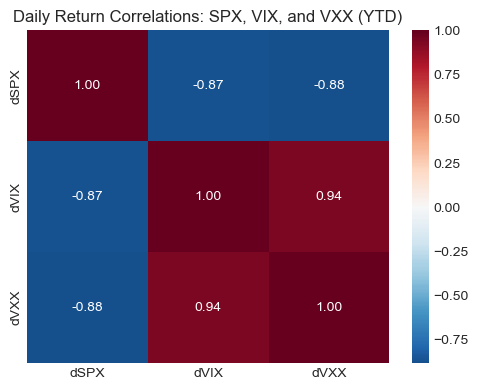

,dSPX,dVIX,dVXX
dSPX,1.000000,-0.867645,-0.881404
dVIX,-0.867645,1.000000,0.936524
dVXX,-0.881404,0.936524,1.000000


In [ ]:
# Static correlations (daily returns)
corr = ret[["dSPX", "dVIX", "dVXX"]].corr()

plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, cmap="RdBu_r", center=0, fmt=".2f")
plt.title("Daily Return Correlations: SPX, VIX, and VXX (YTD)")
plt.tight_layout()
plt.show()

corr

**Rolling Correlation**

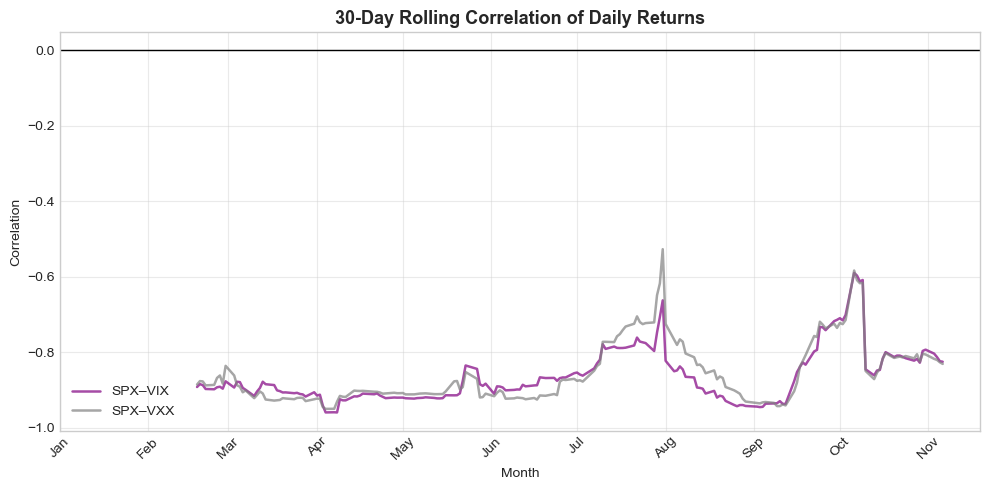

In [23]:
# Rolling 30-day correlation between SPX and VIX/VXX
window = 30
ret["roll_corr_spx_vix"] = ret["dSPX"].rolling(window).corr(ret["dVIX"])
ret["roll_corr_spx_vxx"] = ret["dSPX"].rolling(window).corr(ret["dVXX"])

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(ret["Date"], ret["roll_corr_spx_vix"],
        label="SPX–VIX", color="purple", alpha=0.7, lw=1.8)
ax.plot(ret["Date"], ret["roll_corr_spx_vxx"],
        label="SPX–VXX", color="gray", alpha=0.7, lw=1.8)

ax.axhline(0, color="black", lw=1)
ax.set_title(f"{window}-Day Rolling Correlation of Daily Returns", fontsize=13, weight="bold")
ax.set_ylabel("Correlation")
ax.set_xlabel("Month")

# --- Month tick labels (Jan, Feb, ...) ---
year = ret["Date"].min().year
month_ticks = pd.date_range(start=f"{year}-01-01", end=ret["Date"].max(), freq="MS")
ax.set_xticks(month_ticks)
ax.set_xticklabels(month_ticks.strftime("%b"), rotation=45)

ax.legend(frameon=False, loc="lower left")
ax.grid(alpha=0.4)
plt.tight_layout()
plt.show()

**Sensitivity Analysis**

Computing $\beta$

In [14]:
# OLS: dVIX = α + β * dSPX
X = sm.add_constant(ret["dSPX"])
model_vix = sm.OLS(ret["dVIX"], X).fit()

# OLS: dVXX = α + β * dSPX
model_vxx = sm.OLS(ret["dVXX"], X).fit()

print("=== Regression: SPX vs VIX ===")
print(model_vix.summary().tables[1])
print("\n=== Regression: SPX vs VXX ===")
print(model_vxx.summary().tables[1])

=== Regression: SPX vs VIX ===
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0088      0.003      2.834      0.005       0.003       0.015
dSPX          -6.3183      0.250    -25.289      0.000      -6.811      -5.826

=== Regression: SPX vs VXX ===
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.002      1.400      0.163      -0.001       0.005
dSPX          -3.4080      0.126    -27.040      0.000      -3.656      -3.160


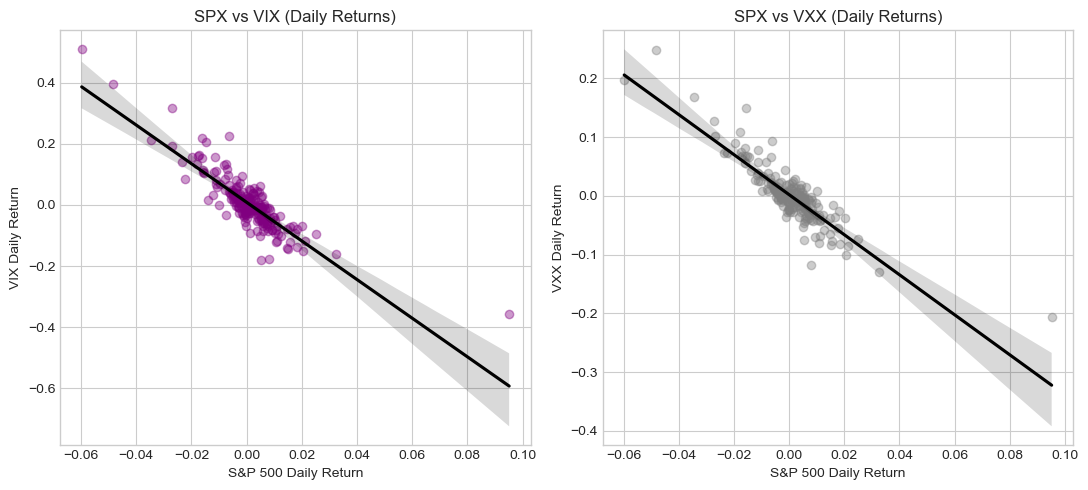

In [15]:
# Scatter with best-fit lines for visual intuition
fig, axes = plt.subplots(1, 2, figsize=(11,5), sharey=False)

sns.regplot(x="dSPX", y="dVIX", data=ret, ax=axes[0],
            scatter_kws=dict(alpha=0.4, color="purple"), line_kws=dict(color="black"))
axes[0].set_title("SPX vs VIX (Daily Returns)")
axes[0].set_xlabel("S&P 500 Daily Return")
axes[0].set_ylabel("VIX Daily Return")

sns.regplot(x="dSPX", y="dVXX", data=ret, ax=axes[1],
            scatter_kws=dict(alpha=0.4, color="gray"), line_kws=dict(color="black"))
axes[1].set_title("SPX vs VXX (Daily Returns)")
axes[1].set_xlabel("S&P 500 Daily Return")
axes[1].set_ylabel("VXX Daily Return")

plt.tight_layout()
plt.show()

In [ ]:
cov_spx_vxx = np.cov(ret["dSPX"], ret["dVXX"], ddof=1)[0,1]
var_vxx     = np.var(ret["dVXX"], ddof=1)
w_star = -cov_spx_vxx / var_vxx

print(f"Static variance-minimizing weight on VXX (w*): {w_star:.3f}")

# Build portfolio returns for SPX only, SPX + w*·VXX, and a milder hedge 0.5·w*
ret["port_spx_only"] = ret["dSPX"]
ret["port_static"]   = ret["dSPX"] + w_star * ret["dVXX"]
ret["port_static_half"] = ret["dSPX"] + 0.5*w_star * ret["dVXX"]

# Cum returns
def cumret(x): 
    return (1 + x).cumprod() - 1

cum = pd.DataFrame({
    "Date": ret["Date"],
    "SPX": cumret(ret["port_spx_only"]),
    "SPX + w*·VXX": cumret(ret["port_static"]),
    "SPX + 0.5w*·VXX": cumret(ret["port_static_half"])
})
cum.tail(1)

Static variance-minimizing weight on VXX (w*): 0.228


,Date,SPX,SPX + w*·VXX,SPX + 0.5w*·VXX
211,2025-11-06,0.145141,0.14594,0.149192


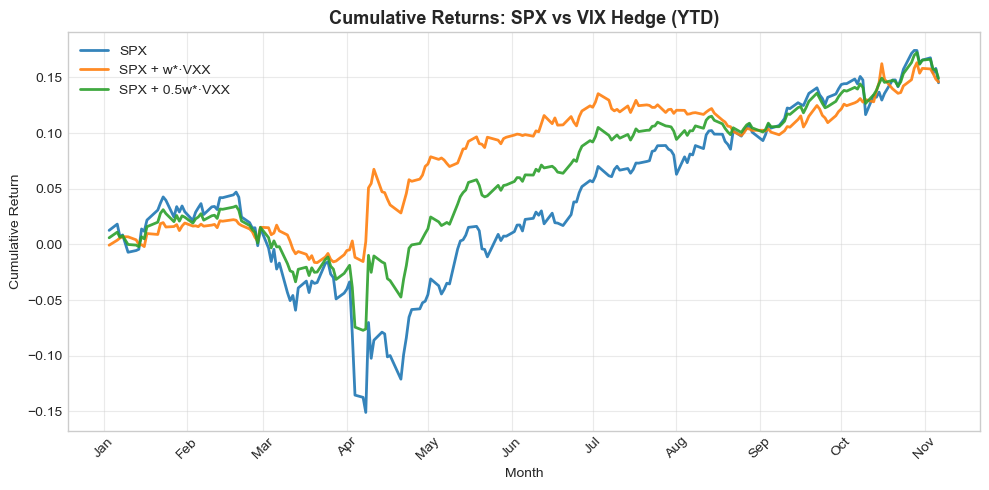

In [26]:
os.makedirs("../reports/figures", exist_ok=True)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(cum["Date"], cum["SPX"],               label="SPX",              lw=2, alpha=0.9)
ax.plot(cum["Date"], cum["SPX + w*·VXX"],      label="SPX + w*·VXX",     lw=2, alpha=0.9)
ax.plot(cum["Date"], cum["SPX + 0.5w*·VXX"],   label="SPX + 0.5w*·VXX",  lw=2, alpha=0.9)

year = ret["Date"].min().year
ticks = pd.date_range(start=f"{year}-01-01", end=ret["Date"].max(), freq="MS")
ax.set_xticks(ticks); ax.set_xticklabels(ticks.strftime("%b"), rotation=45)

ax.set_title("Cumulative Returns: SPX vs VIX Hedge (YTD)", fontsize=13, weight="bold")
ax.set_xlabel("Month"); ax.set_ylabel("Cumulative Return")
ax.grid(alpha=0.4); ax.legend(frameon=False, loc="best")
plt.tight_layout()
plt.savefig("../reports/figures/hedge_cum_returns_static.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
#nSummary metrics for portfolios
def ann_vol(daily_ret, trading_days=252):
    return daily_ret.std(ddof=1) * np.sqrt(trading_days)

def sharpe(daily_ret, rf=0.0, trading_days=252):
    ex = daily_ret - rf/252
    s = ex.mean() / ex.std(ddof=1)
    return s * np.sqrt(trading_days)

def max_drawdown(cum_series):
    peaks = cum_series.cummax()
    dd = (cum_series - peaks) / peaks.replace(0, np.nan)
    return dd.min()

metrics = []
for name, series in {
    "SPX": ret["port_spx_only"],
    "SPX + w*·VXX": ret["port_static"],
    "SPX + 0.5w*·VXX": ret["port_static_half"]
}.items():
    m = {
        "Portfolio": name,
        "Ann.Vol": ann_vol(series),
        "Sharpe(0%)": sharpe(series),
        "MaxDD": max_drawdown((1+series).cumprod())
    }
    metrics.append(m)

metrics_df = pd.DataFrame(metrics).set_index("Portfolio").round(3)
metrics_df

,Ann.Vol,Sharpe(0%),MaxDD
Portfolio,,,
SPX,0.198,0.913,-0.189
SPX + w*·VXX,0.093,1.782,-0.038
SPX + 0.5w*·VXX,0.128,1.358,-0.108


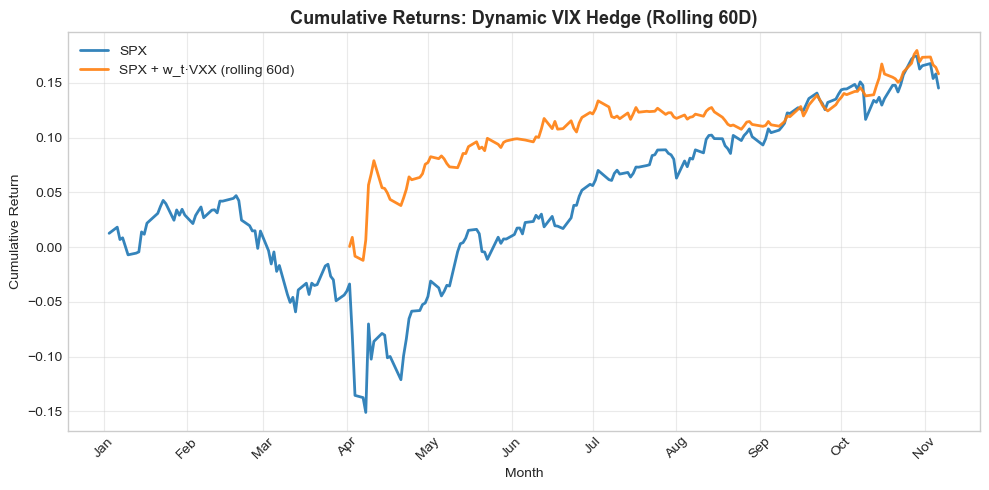

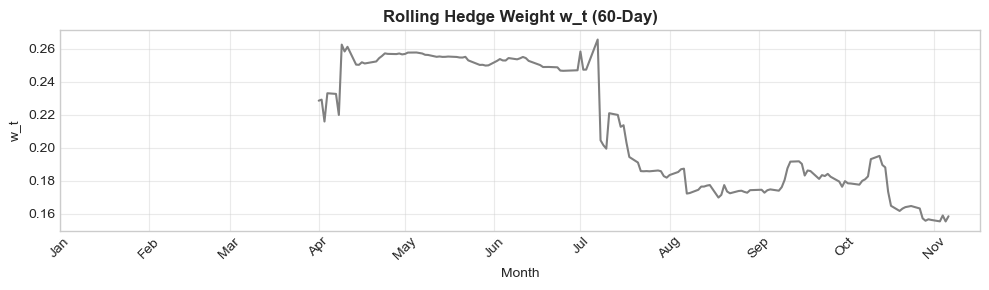

In [ ]:
# Rolling hedge ratio (60-day) via covariance formula
win = 60
roll_cov = ret["dSPX"].rolling(win).cov(ret["dVXX"])
roll_var = ret["dVXX"].rolling(win).var()
ret["w_dyn"] = (-roll_cov / roll_var).clip(-10, 10)  # clip extremes for stability

# Dynamic hedged portfolio (lag weight by 1 day to avoid look-ahead bias)
ret["w_dyn_lag"] = ret["w_dyn"].shift(1)
ret["port_dynamic"] = ret["dSPX"] + ret["w_dyn_lag"]*ret["dVXX"]

cum_dyn = (1 + ret[["port_spx_only","port_dynamic"]]).cumprod() - 1

# Plot
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(ret["Date"], cum_dyn["port_spx_only"], label="SPX", lw=2, alpha=0.9)
ax.plot(ret["Date"], cum_dyn["port_dynamic"],  label="SPX + w_t·VXX (rolling 60d)", lw=2, alpha=0.9)

ticks = pd.date_range(start=f"{year}-01-01", end=ret["Date"].max(), freq="MS")
ax.set_xticks(ticks); ax.set_xticklabels(ticks.strftime("%b"), rotation=45)
ax.set_title("Cumulative Returns: Dynamic VIX Hedge (Rolling 60D)", fontsize=13, weight="bold")
ax.set_xlabel("Month"); ax.set_ylabel("Cumulative Return")
ax.grid(alpha=0.4); ax.legend(frameon=False, loc="best")
plt.tight_layout()
plt.savefig("../reports/figures/hedge_cum_returns_dynamic.png", dpi=300, bbox_inches="tight")
plt.show()

# Visualize the rolling weight
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(ret["Date"], ret["w_dyn"], color="gray", lw=1.5)
ax.set_title("Rolling Hedge Weight w_t (60-Day)", fontsize=12, weight="bold")
ax.set_xlabel("Month"); ax.set_ylabel("w_t")
ax.set_xticks(ticks); ax.set_xticklabels(ticks.strftime("%b"), rotation=45)
ax.grid(alpha=0.4)
plt.tight_layout()
plt.savefig("../reports/figures/hedge_weight_dynamic.png", dpi=300, bbox_inches="tight")
plt.show()


In [29]:
metrics_dyn = []
for name, series in {
    "SPX": ret["port_spx_only"],
    "SPX + w_t·VXX (60d)": ret["port_dynamic"].dropna()
}.items():
    m = {
        "Portfolio": name,
        "Ann.Vol": ann_vol(series.dropna()),
        "Sharpe(0%)": sharpe(series.dropna()),
        "MaxDD": max_drawdown((1+series.dropna()).cumprod())
    }
    metrics_dyn.append(m)

pd.DataFrame(metrics_dyn).set_index("Portfolio").round(3)

,Ann.Vol,Sharpe(0%),MaxDD
Portfolio,,,
SPX,0.198,0.913,-0.189
SPX + w_t·VXX (60d),0.104,2.394,-0.038


In [ ]:
# Event-week comparison: SPX vs hedged around key spike dates
ev = pd.read_csv("../data/interim/vix_spike_annotations.csv", parse_dates=["Date"])
ev = ev[ev["Event"].astype(str).str.strip() != ""].copy()

window = 3  # ±3 trading days around event
rows = []
for d in ev["Date"]:
    if d < ret["Date"].min() or d > ret["Date"].max():
        continue
    # slice ±window days by index
    idx = ret.index[ret["Date"] == d]
    if len(idx)==0: 
        continue
    i = idx[0]
    lo = max(0, i-window); hi = min(len(ret)-1, i+window)
    sl = ret.iloc[lo:hi+1]

    rows.append({
        "EventDate": d.date(),
        "SPX_cum_%": ((1+sl["port_spx_only"]).prod()-1)*100,
        "Static_cum_%": ((1+sl["port_static"]).prod()-1)*100,
        "Dynamic_cum_%": ((1+sl["port_dynamic"].dropna()).prod()-1)*100 if not sl["port_dynamic"].dropna().empty else np.nan
    })

pd.DataFrame(rows).round(2)

,EventDate,SPX_cum_%,Static_cum_%,Dynamic_cum_%
0,2025-03-10,-4.44,-1.70,NaN
1,2025-04-02,-11.08,0.03,-1.21
2,2025-04-08,-5.42,7.27,7.83
3,2025-08-01,-0.70,-0.11,-0.23
4,2025-10-10,-1.03,1.61,1.07
5,2025-10-16,2.79,0.68,1.37


C:\Users\DELL\AppData\Local\Temp\ipykernel_22892\641022281.py:57: UserWarning: Glyph 8348 (\N{LATIN SUBSCRIPT SMALL LETTER T}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\DELL\AppData\Local\Temp\ipykernel_22892\641022281.py:58: UserWarning: Glyph 8348 (\N{LATIN SUBSCRIPT SMALL LETTER T}) missing from font(s) Arial.
  plt.savefig("../reports/figures/hedge_event_weeks.png", dpi=300, bbox_inches="tight")
c:\Users\DELL\miniconda3\envs\vix-project\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8348 (\N{LATIN SUBSCRIPT SMALL LETTER T}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


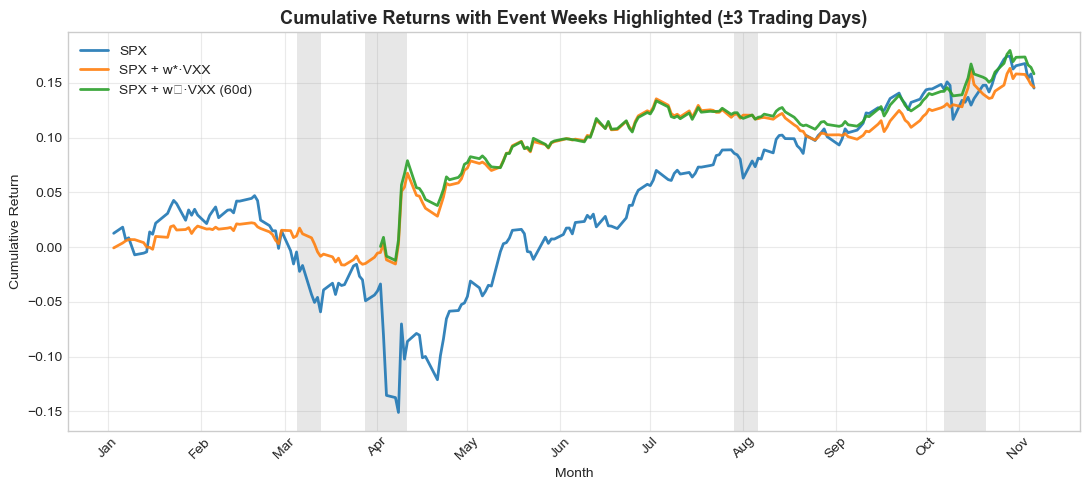

In [ ]:
# load annotated events
ev = pd.read_csv("../data/interim/vix_spike_annotations.csv", parse_dates=["Date"])
ev = ev[ev["Event"].astype(str).str.strip() != ""].copy()
ev = ev.sort_values("Date").drop_duplicates(subset=["Date"])

# build ±window-day intervals around each event
window = 3  # trading days on each side
idx_map = {d: i for i, d in enumerate(ret["Date"])}
intervals = []
for _, r in ev.iterrows():
    d = r["Date"]
    if d not in idx_map:
        prev = ret.loc[ret["Date"] <= d, "Date"].max()
        if pd.isna(prev):
            continue
        d = prev
    i = idx_map[d]
    lo = max(0, i - window)
    hi = min(len(ret) - 1, i + window)
    intervals.append([ret["Date"].iloc[lo], ret["Date"].iloc[hi]])

# merge overlapping intervals
intervals = sorted(intervals, key=lambda x: x[0])
merged = []
for start, end in intervals:
    if not merged or start > merged[-1][1]:
        merged.append([start, end])
    else:
        merged[-1][1] = max(merged[-1][1], end)

# plot cumulative returns with shaded event windows
os.makedirs("../reports/figures", exist_ok=True)

fig, ax = plt.subplots(figsize=(11,5))
ax.plot(cum["Date"], cum["SPX"],               label="SPX",              lw=2, alpha=0.9)
if "SPX + w*·VXX" in cum.columns:
    ax.plot(cum["Date"], cum["SPX + w*·VXX"],  label="SPX + w*·VXX",     lw=2, alpha=0.9)
if "port_dynamic" in ret.columns:
    ax.plot(ret["Date"], (1+ret["port_dynamic"]).cumprod()-1, 
            label="SPX + wₜ·VXX (60d)", lw=2, alpha=0.9)

# shaded event windows
for start, end in merged:
    ax.axvspan(start, end, color="tab:gray", alpha=0.18, lw=0)

# monthly x-axis
year = ret["Date"].min().year
ticks = pd.date_range(start=f"{year}-01-01", end=ret["Date"].max(), freq="MS")
ax.set_xticks(ticks)
ax.set_xticklabels(ticks.strftime("%b"), rotation=45)

ax.set_title("Cumulative Returns with Event Weeks Highlighted (±3 Trading Days)", fontsize=13, weight="bold")
ax.set_xlabel("Month"); ax.set_ylabel("Cumulative Return")
ax.grid(alpha=0.4)
ax.legend(frameon=False, loc="best")

plt.tight_layout()
plt.savefig("../reports/figures/hedge_event_weeks.png", dpi=300, bbox_inches="tight")
plt.show()